In [46]:
import torch
import os
import pandas as pd
import scipy
import torchvision
from torch import optim,nn
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from utils import StanfordCars, parse_transforms
import yaml
from train_ae import CAE


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu",0)
print("Device used: ",device)

path = "./defaults.yml"
with open(path, "r") as stream: params = yaml.safe_load(stream)

test_batch = params["test_batch"]
img_size = params["img_size"]
transforms = params["transforms"].split(',')
model_path = params["model_paths"][len(params["model_paths"])-1]
print("Model path = ",model_path)

test_dataset = StanfordCars(root=params["dataset_path"],split ="validation",transform=parse_transforms(transforms,img_size))
test_loader = torch.utils.data.DataLoader(  test_dataset, test_batch, shuffle=False, num_workers=4, pin_memory=True)

model = CAE(3,3,img_size,params["latent_dim"])
model.load_state_dict(torch.load(model_path))

def imshowo(img):
    
    img = img.numpy()
   
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

Device used:  cuda:0
Model path =  ./models/CAE 14Sep15h01/model.pth


[tensor(0.1020), tensor(0.1255), tensor(0.1804), tensor(0.2549), tensor(0.2510), tensor(0.1961), tensor(0.1569), tensor(0.1373), tensor(0.1137), tensor(0.1176), tensor(0.1255), tensor(0.1176), tensor(0.1216), tensor(0.1176), tensor(0.1216), tensor(0.1255), tensor(0.1255), tensor(0.1294), tensor(0.1294), tensor(0.1294), tensor(0.1333), tensor(0.1373), tensor(0.1059), tensor(0.0941), tensor(0.0941), tensor(0.0941), tensor(0.0824), tensor(0.0588), tensor(0.0824), tensor(0.0941), tensor(0.0745), tensor(0.0549), tensor(0.4275), tensor(0.6078), tensor(0.5569), tensor(0.4588), tensor(0.3098), tensor(0.0353), tensor(0.2118), tensor(0.3882), tensor(0.1059), tensor(0.0941), tensor(0.0431), tensor(0.0039), tensor(0.0039), tensor(0.0039), tensor(0.0118), tensor(0.0196), tensor(0.0157), tensor(0.0118)]


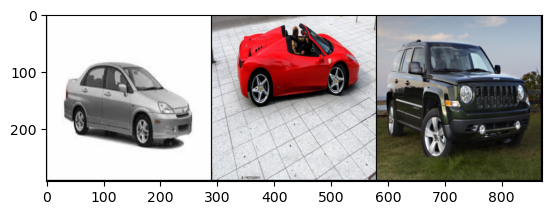

[tensor(0.6428), tensor(0.6460), tensor(0.6415), tensor(0.6438), tensor(0.6406), tensor(0.6445), tensor(0.6460), tensor(0.6465), tensor(0.6396), tensor(0.6401), tensor(0.6339), tensor(0.6352), tensor(0.6326), tensor(0.6345), tensor(0.6365), tensor(0.6362), tensor(0.6304), tensor(0.6296), tensor(0.6280), tensor(0.6260), tensor(0.6160), tensor(0.6130), tensor(0.6086), tensor(0.6044), tensor(0.5894), tensor(0.5838), tensor(0.5695), tensor(0.5668), tensor(0.5598), tensor(0.5576), tensor(0.5496), tensor(0.5494), tensor(0.5460), tensor(0.5465), tensor(0.5468), tensor(0.5468), tensor(0.5426), tensor(0.5428), tensor(0.5412), tensor(0.5406), tensor(0.5334), tensor(0.5322), tensor(0.5259), tensor(0.5241), tensor(0.5212), tensor(0.5201), tensor(0.5151), tensor(0.5144), tensor(0.5171), tensor(0.5163)]


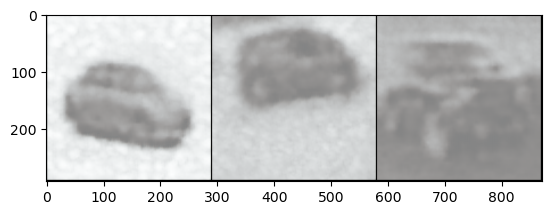

In [52]:
images,_ =  iter(test_loader).next()
nb = 3
images = images[0:nb]

images_grid = torchvision.utils.make_grid(images)

samp = images_grid[1][50][400:450]
print(list(samp))

imshowo(images_grid)

outputs = model(images)
rep = outputs.view(nb,3,img_size,img_size)

rep = torchvision.utils.make_grid(rep)

samp = rep[1][50][400:450]
print(list(samp))

rep -= torch.min(rep)
rep /= torch.max(rep)
rep = torch.nan_to_num(rep)

imshowo(rep)